In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.cluster import KMeans
import shap


In [2]:
anemia_df = pd.read_csv("anemia.csv")
pcos_df = pd.read_csv("PCOS_infertility.csv")
period_df = pd.read_csv("Period_Log.csv")
profile_df = pd.read_csv("User_Profile.csv")


In [3]:
anemia_label = anemia_df["Result"]


In [4]:
pcos_label = pcos_df["PCOS (Y/N)"]


In [7]:
print(period_df.columns)
period_agg = period_df.groupby("user_id").agg({
    "cycle_length_days": "mean",
    "pain_level": "mean",
    "mood_score": "mean",
    "stress_score_cycle": "mean",
    "sleep_hours_cycle": "mean",
    "energy_level": "mean",
    "concentration_score": "mean",
    "work_hours_lost": "mean"
}).reset_index()


Index(['user_id', 'cycle_number', 'start_date', 'cycle_length_days',
       'prev_cycle_length', 'cycle_phase', 'flow_level', 'pain_level',
       'pms_symptoms', 'mood_score', 'stress_score_cycle', 'sleep_hours_cycle',
       'energy_level', 'concentration_score', 'work_hours_lost',
       'estrogen_pgml', 'progesterone_ngml', 'ovulation_result',
       'overall_health_score', 'log_consistency_score',
       'prepared_before_period'],
      dtype='object')


In [8]:
profile = profile_df.copy()

categorical_cols = [
    "diet_quality", "exercise_frequency", "alcohol_consumption",
    "smoking_status", "state"
]

le = LabelEncoder()
for col in categorical_cols:
    profile[col] = le.fit_transform(profile[col])

profile["birth_control_use"] = profile["birth_control_use"].astype(int)


In [9]:
user_features = pd.merge(period_agg, profile, on="user_id", how="inner")


In [10]:
cluster_features = user_features[[
    "cycle_length_days",
    "mood_score",
    "stress_score_cycle",
    "sleep_hours",
    "energy_level",
    "concentration_score"
]]


In [11]:
scaler_cluster = StandardScaler()
cluster_scaled = scaler_cluster.fit_transform(cluster_features)


In [12]:
kmeans = KMeans(n_clusters=2, random_state=42)
user_features["hormonal_cluster"] = kmeans.fit_predict(cluster_scaled)


In [14]:
numeric_cols = user_features.select_dtypes(include=["int64", "float64"]).columns

cluster_summary = (
    user_features
    .groupby("hormonal_cluster")[numeric_cols]
    .mean()
)

cluster_summary


,cycle_length_days,pain_level,mood_score,stress_score_cycle,sleep_hours_cycle,energy_level,concentration_score,work_hours_lost,state,age,...,diet_quality,exercise_frequency,sleep_hours,caffeine_intake,water_intake_liters,alcohol_consumption,smoking_status,birth_control_use,pcos_diagnosed,stress_score_baseline
hormonal_cluster,,,,,,,,,,,,,,,,,,,,,
0,27.891508,5.864006,6.471603,6.875085,6.811815,6.070723,6.693568,4.126502,24.698537,25.708293,...,1.286829,1.209756,7.008488,1.788878,2.279220,0.630244,0.112195,0.327805,0.112195,6.661268
1,27.731443,3.774704,7.736383,4.557783,7.120626,7.639273,8.046405,2.608583,24.824615,25.845128,...,1.369231,1.231795,6.979179,1.844718,2.329436,0.653333,0.099487,0.364103,0.050256,4.460410


In [15]:
imbalanced_cluster = cluster_summary["cycle_length_days"].idxmax()

user_features["Hormonal_Imbalance"] = (
    user_features["hormonal_cluster"] == imbalanced_cluster
).astype(int)


In [16]:
min_samples = min(
    len(user_features),
    len(anemia_label),
    len(pcos_label)
)

X = user_features.iloc[:min_samples].drop(columns=["user_id", "hormonal_cluster"])
Y = pd.DataFrame({
    "Anemia": anemia_label.iloc[:min_samples].values,
    "PCOS": pcos_label.iloc[:min_samples].values,
    "Hormonal_Imbalance": user_features["Hormonal_Imbalance"].iloc[:min_samples].values
})


In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=42
)


NameError: name 'df' is not defined

In [19]:
model = MultiOutputClassifier(
    RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    )
)

model.fit(X_train, Y_train)


MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       n_estimators=300,
                                                       random_state=42))

In [20]:
Y_pred = model.predict(X_test)

print("Anemia Report")
print(classification_report(Y_test["Anemia"], Y_pred[:,0]))

print("PCOS Report")
print(classification_report(Y_test["PCOS"], Y_pred[:,1]))

print("Hormonal Imbalance Report")
print(classification_report(Y_test["Hormonal_Imbalance"], Y_pred[:,2]))


Anemia Report
              precision    recall  f1-score   support

           0       0.64      0.74      0.69        66
           1       0.47      0.35      0.40        43

    accuracy                           0.59       109
   macro avg       0.55      0.55      0.54       109
weighted avg       0.57      0.59      0.57       109

PCOS Report
              precision    recall  f1-score   support

           0       0.70      0.95      0.81        77
           1       0.20      0.03      0.05        32

    accuracy                           0.68       109
   macro avg       0.45      0.49      0.43       109
weighted avg       0.55      0.68      0.59       109

Hormonal Imbalance Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        55
           1       1.00      1.00      1.00        54

    accuracy                           1.00       109
   macro avg       1.00      1.00      1.00       109
weighted avg       1.0

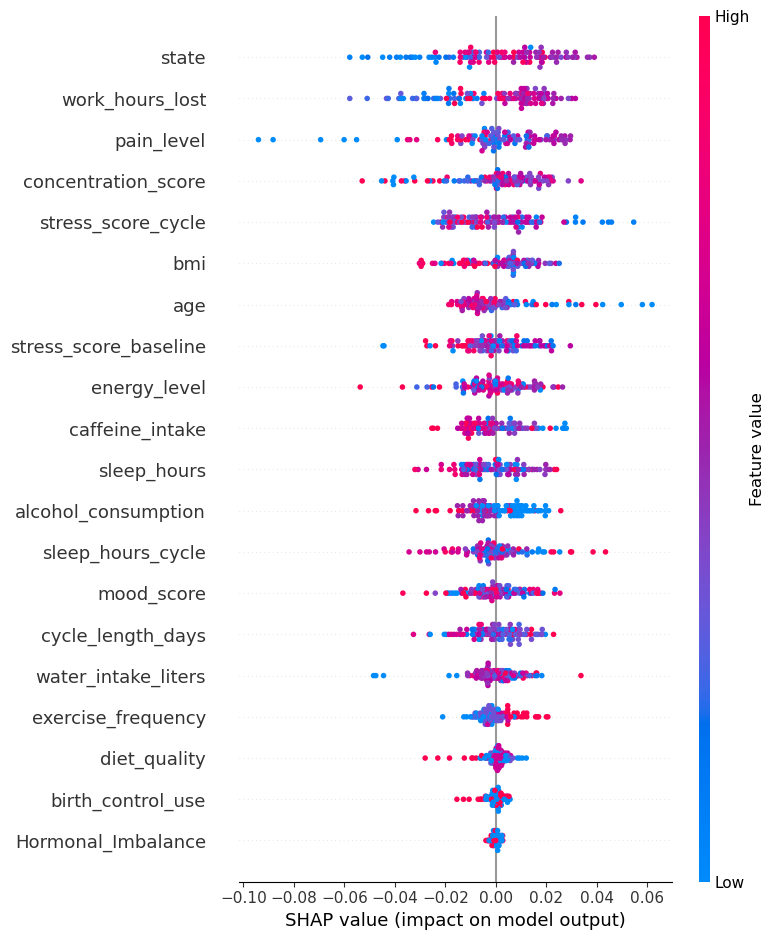

In [24]:
X_test_df = pd.DataFrame(X_test, columns=X.columns)

explainer = shap.Explainer(pcos_model, X_test_df)
shap_values = explainer(X_test_df)
shap.summary_plot(
    shap_values[:, :, 1],
    X_test_df
)


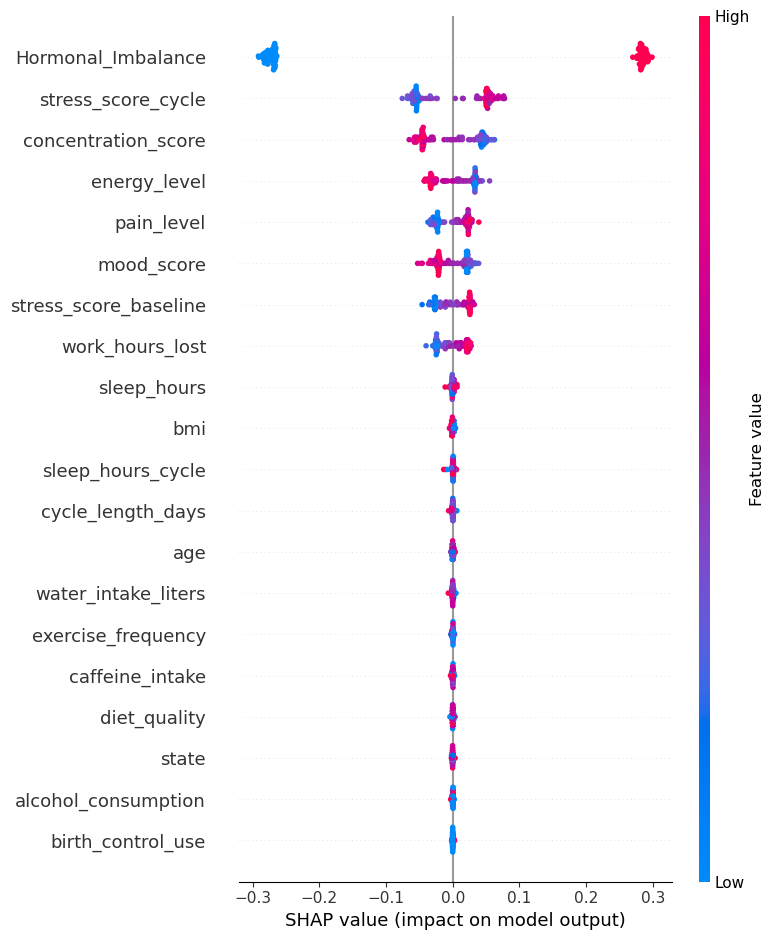

In [27]:
X_test_df = pd.DataFrame(X_test, columns=X.columns)
hormonal_model = model.estimators_[2]
explainer = shap.Explainer(hormonal_model, X_test_df)
shap_values = explainer(X_test_df)
shap.summary_plot(
    shap_values[:, :, 1],
    X_test_df
)


In [29]:
shap.initjs()
explainer = shap.Explainer(hormonal_model, X_test_df)
shap_values = explainer(X_test_df)
shap.force_plot(
    shap_values[0, :, 1]
)


In [33]:
import pickle

# Save trained model
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save column names (VERY IMPORTANT)
with open("columns.pkl", "wb") as f:
    pickle.dump(X.columns.tolist(), f)
